<span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">⚡ Electricity Production Forecasting ⚡</span>

In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np

import io
from google.colab import files

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import pmdarima as pm

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id = "2"></a><h1 id="Loading Data"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Loading Data</span></h1>

In [ ]:
uploaded = files.upload()
col_names = ["date", "value"]
df = pd.read_csv(io.BytesIO(uploaded['Electric_Production.csv']), index_col=0,
                 names = col_names, header = 0, parse_dates = [0])
df.head()

Saving Electric_Production.csv to Electric_Production.csv


,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


# ETS Model
## Plotting the Series
The plot of the series may help us to decide about specification of the model. Three important observations


*   Series is heteroskedastic - variance grows with increasing production
*   Sesonality is growing with production
*   Linear trend till 2008, then it stabilizes

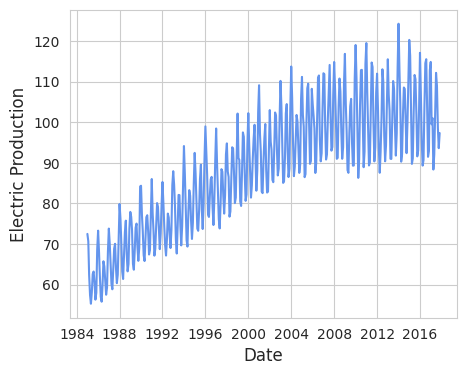

In [ ]:
plt.figure(figsize = (5, 4))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

## ETS Model Estimation
Based on the observations above multiplicative errors and seasons seems to be a reasonable specification.

In [ ]:
ets = ETSModel(df['value'], error='mul', seasonal='mul', seasonal_periods=12, initialization_method='estimated')
ets = ets.fit()
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  value   No. Observations:                  394
Model:                       ETS(MNM)   Log Likelihood                -875.800
Date:                Tue, 20 Jun 2023   AIC                           1783.599
Time:                        09:35:19   BIC                           1847.221
Sample:                    02-01-1985   HQIC                          1808.809
                         - 11-01-2017   Scale                            0.001
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5292      0.074      7.188      0.000       0.385       0.674
smoothing_seasonal      0.1642      0.033      5.050      0.000       0.100       0.228
initial_level          69.4476    947.284      0.073      0.942   -1787.195    1926.090
initial_seasonal.0      1.0510     14.336      0.073      0.942     -27.047      29.149
initial_seasonal.1      0.9772     13.329      0.073      0.942     -25.146      27.101
initial_seasonal.2      0.8495     11.587      0.073      0.942     -21.861      23.560
initial_seasonal.3      0.8210     11.199      0.073      0.942     -21.128      22.770
initial_seasonal.4      0.8766     11.956      0.073      0.942     -22.558      24.311
initial_seasonal.5      0.9471     12.919      0.073      0.942     -24.374      26.268
initial_seasonal.6      0.9509     12.970      0.073      0.942     -24.470      26.372
initial_seasonal.7      0.8864     12.091      0.073      0.942     -22.812      24.584
initial_seasonal.8      0.8285     11.301      0.073      0.942     -21.322      22.979
initial_seasonal.9      0.8470     11.553      0.073      0.942     -21.797      23.491
initial_seasonal.10     0.9277     12.654      0.073      0.942     -23.873      25.728
initial_seasonal.11     1.0000     13.640      0.073      0.942     -25.734      27.734
===================================================================================
Ljung-Box (Q):                       67.63   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.00   Prob(JB):                         0.21
Heteroskedasticity (H):               1.67   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

## Fitted Values

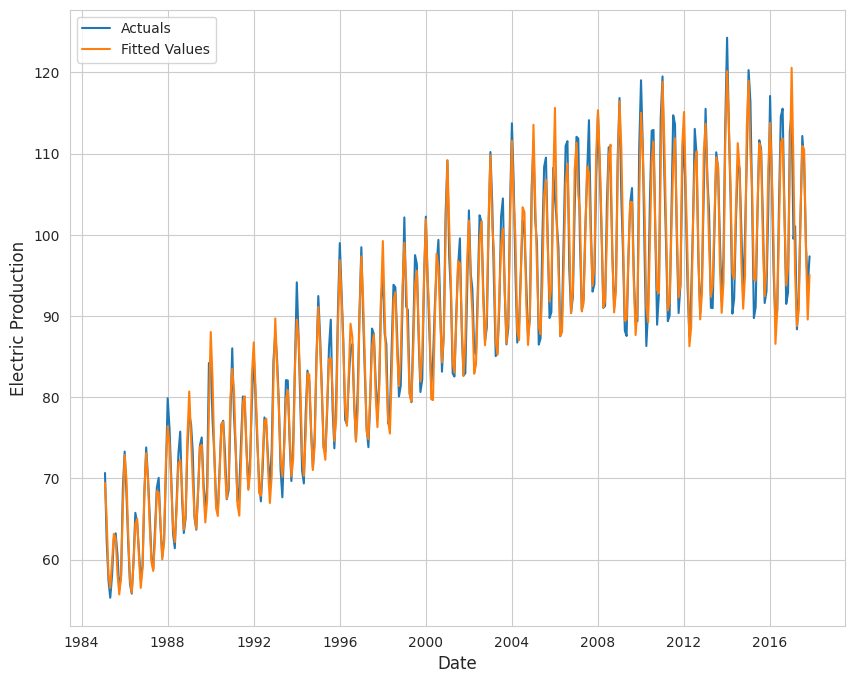

In [ ]:
fitted_ets = ets.predict(dynamic=False)
plt.figure(figsize = (10, 8))
plt.plot(df['value'], label = "Actuals")
plt.plot(fitted_ets, '-', label = "Fitted Values")
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.legend()
plt.show()

## Seasonality

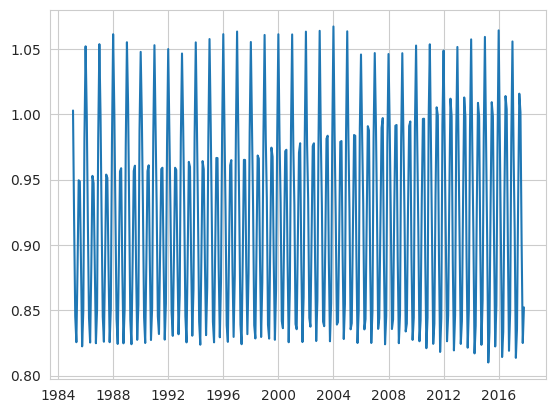

In [ ]:
plt.plot(ets.season)
plt.show()

## ETS Forecast - One Year Ahead


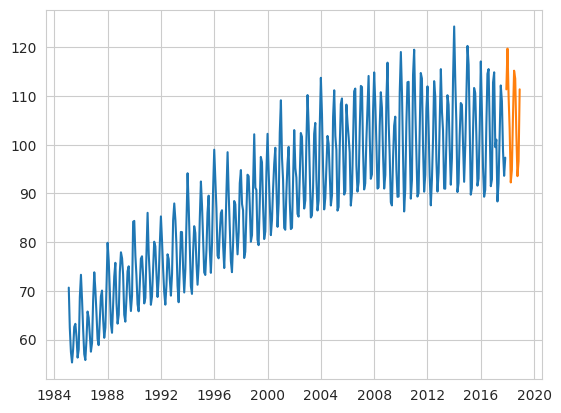

In [ ]:
HORIZON = 12 # 12 months
forecasted_ets = ets.predict(start = len(df['value']), end = len(df['value']) + HORIZON,dynamic=False)
plt.plot(df['value'], label = "Historical Data")
plt.plot(forecasted_ets, label = "Forecast")
plt.show()

# ARIMA

##Checking Stationarity

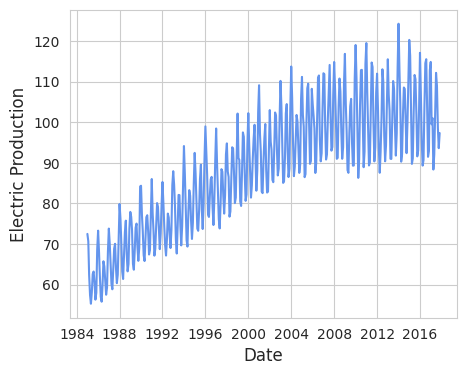

In [ ]:
plt.figure(figsize = (5, 4))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

<a id = "7"></a><h1 id="Augmented Dickey-Fuller Test"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Augmented Dickey-Fuller Test</p></h1>

**Null Hypothesis:** Time Series is non-stationary. It gives a time-dependent trend.

**Alternative Hypothesis:** Time Series is stationary. In another term, the series doesn’t depend on time.

In [ ]:
# Perform the ADF test
ad = adfuller(df['value'])

# Extract and print the test statistics
print(f'p-value: {ad[1]}')

p-value: 0.08779764007685703


The p-value is greater than significance level of 0.05, so we do not reject the null hypothesis. ---> The time series is **non-stationary**.

##Converting Data to Stationary

In [ ]:
# Perform first differencing
df['value_stationary'] = df['value'].diff()

df.dropna(inplace=True)

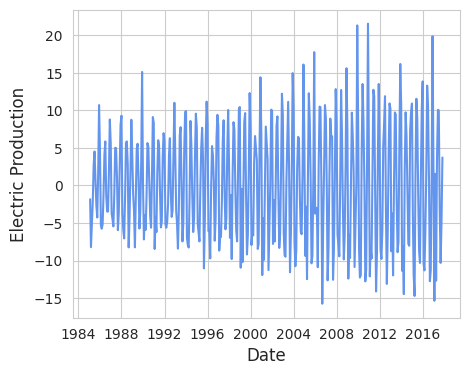

In [ ]:
plt.figure(figsize = (5,4))
plt.plot(df['value_stationary'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

In [ ]:
# Perform the ADF test
ad = adfuller(df['value_stationary'])

# Extract and print the test statistics
print(f'p-value: {ad[1]}')

p-value: 2.789506529307676e-10


# Forecasting with ARIMA

### Train/Test Split

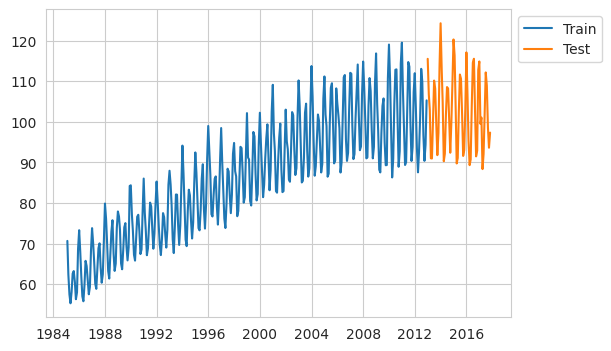

In [ ]:
# Train Test Split Index
train_size = 0.85
split_idx = round(len(df['value_stationary'])* train_size)
split_idx

# Split
train = df['value_stationary'].iloc[:split_idx]
test = df['value_stationary'].iloc[split_idx:]

train_orig = df['value'].iloc[:split_idx]
test_orig = df['value'].iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(6, 4))
plt.plot(train_orig, label='Train')
plt.plot(test_orig, label='Test')
ax.legend(bbox_to_anchor=[1,1]);

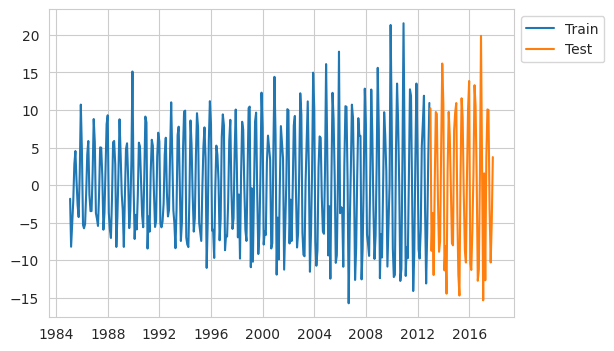

In [ ]:
# Visualize split
fig,ax= plt.subplots(figsize=(6, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
ax.legend(bbox_to_anchor=[1,1]);

### Find the best ARIMA specification using auto_arima

In [ ]:
# Fit the auto_arima model to automatically select the best parameters
model = pm.auto_arima(train, seasonal=False, trace=True)

# Print the best model parameters
print(model.order)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2291.016, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2241.499, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2177.135, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2178.552, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2103.777, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2075.340, Time=0.38 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2041.520, Time=0.52 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2041.312, Time=0.65 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2023.609, Time=0.58 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2023.924, Time=0.82 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1956.779, Time=0.84 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=1947.452, Time=1.17 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=1732.403, Time=2.95 sec
 ARIMA(2,0,4)(0,0,0)[0]             : 

### Fit the selected model on train data

In [ ]:
model = ARIMA(train, order=(2, 0, 5))
ARIMA_model = model.fit()

In [ ]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       value_stationary   No. Observations:                  335
Model:                 ARIMA(2, 0, 5)   Log Likelihood                -842.081
Date:                Tue, 20 Jun 2023   AIC                           1702.162
Time:                        09:25:35   BIC                           1736.489
Sample:                    02-01-1985   HQIC                          1715.847
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1217      0.016      7.508      0.000       0.090       0.153
ar.L1          0.9960      0.004    238.819      0.000       0.988       1.004
ar.L2         -0.9977      0.003   -324.800      0.000      -1.004      -0.992
ma.L1         -1.3477      0.050    -26.976      0.000      -1.446      -1.250
ma.L2          0.9432      0.087     10.786      0.000       0.772       1.115
ma.L3         -0.0920      0.109     -0.844      0.399      -0.306       0.122
ma.L4         -0.3623      0.100     -3.640      0.000      -0.557      -0.167
ma.L5         -0.0550      0.059     -0.925      0.355      -0.171       0.061
sigma2         8.4122      0.591     14.233      0.000       7.254       9.571
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):                25.23
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Use fitted ARIMA to forecast across testing date range and compare to original testing data

In [ ]:
START = len(train)
print(START)

END = len(train) + len(test) - 1
print(END)

335
393


We start calculating predictions from 335th month (start of test set date range) till 393rd month (end of our series).

In [ ]:
test_forecast = ARIMA_model.predict(start=START, end=END, dynamic=False)
arima_score = mean_squared_error(test, test_forecast)
print('ARIMA MSE: {}'.format(round(arima_score, 3)))

ARIMA MSE: 18.812


Let's see how are the predictions matching the true values.

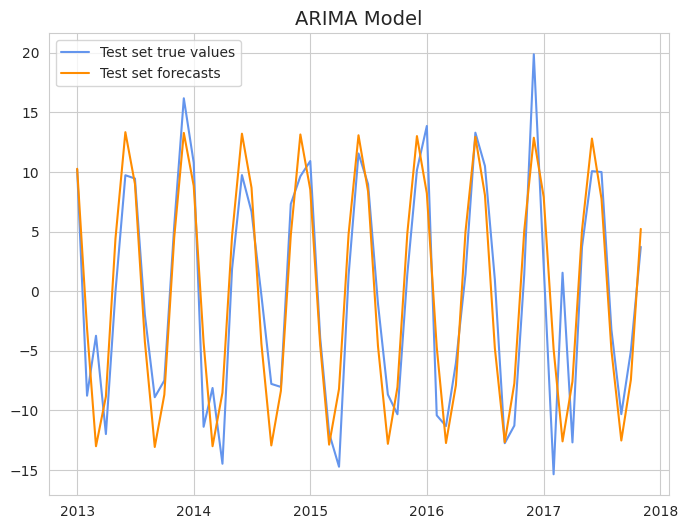

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(test, label = "Test set true values", color = "cornflowerblue")
plt.plot(test_forecast, label = "Test set forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

##One year out-of-sample forecast with fitted ARIMA

In [ ]:
# Perform out-of-sample forecast
oos_forecast = ARIMA_model.predict(start=START, end=END + 12, dynamic=False)

#Print the last observed values
print(test_orig[-3:])

# Print the forecasted values
print(oos_forecast[-12:])

date
2017-09-01    98.6154
2017-10-01    93.6137
2017-11-01    97.3359
Name: value, dtype: float64
2017-12-01    12.735293
2018-01-01     7.593456
2018-02-01    -5.021555
2018-03-01   -12.455969
2018-04-01    -7.274152
2018-05-01     5.304622
2018-06-01    12.663053
2018-07-01     7.441711
2018-08-01    -5.100617
2018-09-01   -12.383313
2018-10-01    -7.122902
2018-11-01     5.382776
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
# Values are first-differenced, we need to revert them back
# We take the last observed value (test_orig[-1]), and add all the differences that were predicted since then
forecast_orig = test_orig[-1] + np.cumsum(oos_forecast[-12:])

print(forecast_orig)

2017-12-01    110.071193
2018-01-01    117.664649
2018-02-01    112.643094
2018-03-01    100.187125
2018-04-01     92.912973
2018-05-01     98.217596
2018-06-01    110.880649
2018-07-01    118.322360
2018-08-01    113.221743
2018-09-01    100.838430
2018-10-01     93.715528
2018-11-01     99.098304
Freq: MS, Name: predicted_mean, dtype: float64


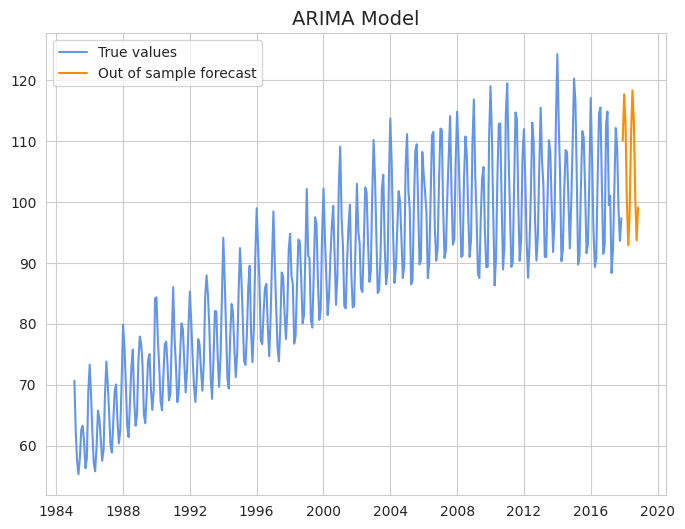

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(df['value'], label = "True values", color = "cornflowerblue")
plt.plot(forecast_orig, label = "Out of sample forecast", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

# Precision Comparison - MAE
Average difference between forecasted and observed values in the testing dataset.

$MAE = \frac{\sum_{i=1}^n|y_{T+i}-\widehat{y}_{T+i|T}|}{n}$

In [ ]:
# ARIMA Results
model = ARIMA(train, order=(2, 0, 5))
ARIMA_model = model.fit()
test_forecast = ARIMA_model.predict(start=START, end=END, dynamic=False)
arima_score = mean_squared_error(test, test_forecast)
print('ARIMA MAE: {}'.format(round(arima_score, 3)))

# ETS
ets = ETSModel(train_orig, error='mul', trend=None, seasonal='mul', seasonal_periods=12, initialization_method='estimated')
ets = ets.fit()
test_forecast_ets = ets.predict(start=START, end=END, dynamic=False)
ets_score = mean_squared_error(test_orig, test_forecast_ets)
print('ETS MAE: {}'.format(round(ets_score, 3)))

# Naive - last observed value
naive_forecast = np.repeat(train_orig[-1], len(test_orig))
naive_score = mean_squared_error(test_orig, naive_forecast)
print('Naive MAE: {}'.format(round(naive_score, 3)))

# Simple mean
mean_forecast = np.repeat(np.mean(train_orig), len(test_orig))
mean_score = mean_squared_error(test_orig, mean_forecast)
print('Simple mean MAE: {}'.format(round(mean_score, 3)))

# SNaive
n_seasons = 12
snaive_forecast = np.tile(train_orig[-n_seasons:], int(np.ceil(len(test_orig)/n_seasons))) # repeats last 12 values for ceil(number of years in testing dataset)
snaive_forecast = snaive_forecast[:len(test_orig)] # removes forecast beyond horizon to match length with testing_dataset
snaive_score = mean_squared_error(test_orig, snaive_forecast)
print('Snaive MAE: {}'.format(round(snaive_score, 3)))

ARIMA MAE: 18.812
ETS MAE: 17.875
Naive MAE: 92.284
Simple mean MAE: 350.049
Snaive MAE: 23.378


# Why do simple mean and naive perform so bad?

The simple mean does not capture seasonality, which is locally the most important feature of the data, but also the long term trend. Naive model can somewhat capture the trend, since we are using the most recent value, but seasonality is ignored.



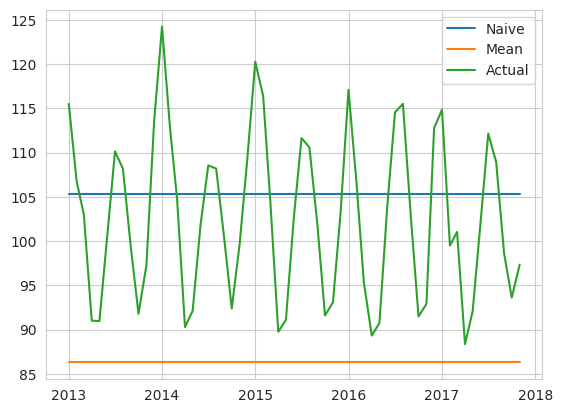

In [ ]:
naive_forecast = pd.Series(data=naive_forecast, index = test_orig.index) # We have to create pandas Series and assign dates to correctly plot the data
mean_forecast = pd.Series(data=mean_forecast, index = test_orig.index)

plt.plot(naive_forecast, label = "Naive")
plt.plot(mean_forecast, label = "Mean")
plt.plot(test_orig, label = "Actual")
plt.legend()

**References:**

https://machinelearningmastery.com/
https://otexts.com/fpp2/index.html

https://www.kaggle.com/code/sercanyesiloz/electricity-production-forecasting-arima/notebook

https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/